Импорт необходимых библиотек

In [12]:

import pandas as pd # пандас для работы с датафреймами
import matplotlib.pyplot as plt # Библиотека для создания визуализаций данных.
import warnings # Используется для управления предупреждениями (warnings) в Python.
import matplotlib.pyplot as plt #Библиотека для создания визуализаций данных.
import matplotlib.dates as mdates #форматирование,отображение и манипуляция с датами на графиках
import numpy as np #Библиотека для численных вычислений.предоставляет поддержку многомерных массивов и матриц
from datetime import datetime# Модуль для работы с датами и временем.
from statsmodels.graphics.tsaplots import plot_acf   # Функция для построения графика автокорреляционной функции (ACF).
from statsmodels.graphics.tsaplots import plot_pacf   # Функция для построения графика частичной автокорреляционной функции (PACF).
from sklearn.model_selection import ParameterGrid # Используется для создания сетки параметров для перебора при настройке моделей.
from statsmodels.tools.sm_exceptions import ConvergenceWarning #Предупреждение о сходимости.
from joblib import Parallel, delayed #для параллельного выполнения кода.
from statsmodels.tsa.seasonal import seasonal_decompose #функция для декомпозиции временных рядов, сезонную составляющую и остаток
from pylab import rcParams #параметры для графиков
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tqdm import tqdm #Библиотека для отображения индикатора прогресса при выполнении итераций в циклах
from statsmodels.tsa.arima.model import ARIMA #Библиотека для статистического анализа и построения временных рядов.


Код для разделения на разные файлы для REZ 

In [13]:
 # Преобразуем строку в формат datetime
def parse(x):
    return datetime.strptime(x, '%y-%m-%d %H:%M:%S.%f')

warnings.simplefilter(action='ignore', category=FutureWarning)
# Считывание данных из CSV-файла
rz = pd.read_csv('Кран/Rez/Rez_Month.csv', parse_dates={'Datetime': ['Дата', 'Время']}, date_parser=parse)

# Установка индекса как временного ряда
rz.set_index('Datetime', inplace=True)

# Преобразование индекса в формат времени только по дням
rz.index = rz.index.map(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# Сохранение данных в отдельные CSV файлы для каждого статуса
for rez, group in rz.groupby('Результат'):
    #По какой переменной будет подсчет(по дням = D)
    rez_counts = group.groupby(pd.Grouper(freq='D')).size()# Группируем данные по дням и подсчитываем количество записей в столбце 'ID'
    rez_counts.to_csv(f'Кран/Rez/{rez}_Month.csv', header=[rez], index=True)#Запись файлов в папку

Чтение данных со всех файлов

In [14]:
 # Преобразуем строку в формат datetime
def parser(x):
   
    return datetime.strptime(x, '%y-%m-%d %H:%M:%S.%f')

# Преобразуем строку в формат datetime
def parser1(x):
    return pd.to_datetime(x)


ID = pd.read_csv('Кран/ID_Month.csv', parse_dates={'Datetime': ['Дата', 'Время']}, date_parser=parser)# Считываем данные из CSV-файлов

ID.set_index('Datetime', inplace=True)# Устанавливаем индекс DataFrame на столбец 'Datetime'
ID = ID.sort_index() # Сортируем DataFrame по индексу (по времени)
ID.index = ID.index.map(lambda x: x.replace(hour=0,minute=0, second=0, microsecond=0))# Обнуляем часы, минуты, секунды и микросекунды в индексе
ID = ID['ID'].groupby(pd.Grouper(freq='D')).count()# Группируем данные по дням и подсчитываем количество записей в столбце 'ID'

WAR = pd.read_csv('Кран/Rez/WAR_Month.csv', parse_dates=['Datetime'], date_parser=parser1)# Считываем данные из CSV-файлов 
WAR.set_index('Datetime', inplace=True)# Устанавливаем индекс DataFrame на столбец 'Datetime'

SUC = pd.read_csv('Кран/Rez/SUC_Month.csv', parse_dates=['Datetime'], date_parser=parser1)# Считываем данные из CSV-файлов 
SUC.set_index('Datetime', inplace=True)# Устанавливаем индекс DataFrame на столбец 'Datetime'

S_OK = pd.read_csv('Кран/Rez/S_OK_Month.csv', parse_dates=['Datetime'], date_parser=parser1)# Считываем данные из CSV-файлов 
S_OK.set_index('Datetime', inplace=True)# Устанавливаем индекс DataFrame на столбец 'Datetime'

ERR = pd.read_csv('Кран/Rez/ERR_Month.csv', parse_dates=['Datetime'], date_parser=parser1)# Считываем данные из CSV-файлов 
ERR.set_index('Datetime', inplace=True)# Устанавливаем индекс DataFrame на столбец 'Datetime'



Выбор кол-ва данных для прогноза в % , заполнение массивов данными


In [15]:
percentsize=1 #100%

#массив для всех файлов 
allGr = [
    ID[:int(len(ID) * percentsize)],
    WAR[:int(len(WAR) * percentsize)],
    SUC[:int(len(SUC) * percentsize)],
    S_OK[:int(len(S_OK) * percentsize)],
    ERR[:int(len(ERR) * percentsize)]
]
#массив имен для всех файлов   
nameGr=['id','WAR','SUC','S_OK','ERR']



Построение графиков для каждого файла

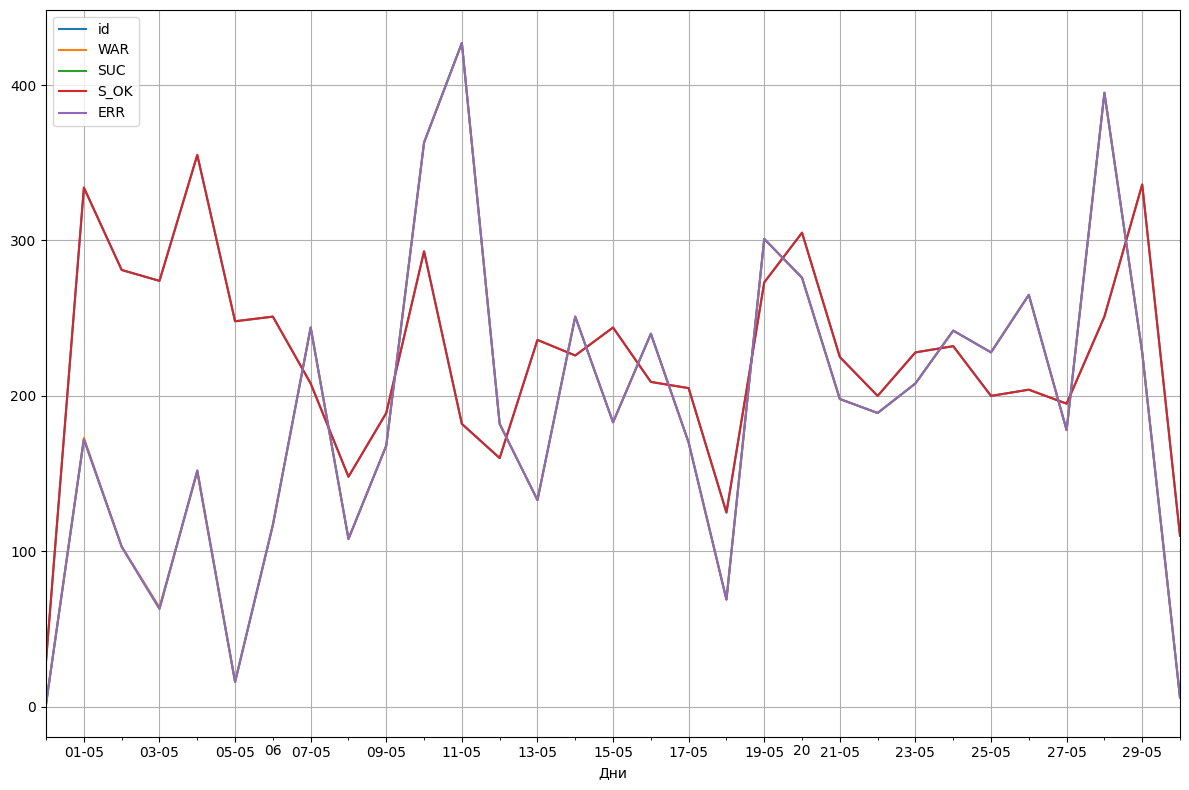

In [16]:


date_form = mdates.DateFormatter("%d-%m") # Устанавливаем формат даты для графиков в виде "день-месяц"


fig, ax = plt.subplots(figsize=(12, 8)) # Создаем новую фигуру и ось для графиков

# Строим каждый график
for graf, nameG in zip(allGr, nameGr): #данные берутся из заданных массивов в начале
    graf.plot(ax=ax, label=nameG)


ax.set_xlabel('Дни') # Задаем название оси x как 'Дни'
ax.xaxis.set_major_formatter(date_form) # Устанавливаем основной формат даты на оси x с использованием ранее заданного формата
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))# Устанавливаем основной тип для оси x, чтобы показывать деления каждые 2 дня
plt.legend() # Добавляем легенду на график
plt.grid()# Включаем сетку на графике
plt.tight_layout()# Автоматически корректируем плотность компонентов на графике для лучшего визуального восприятия
plt.show() # Отображаем график

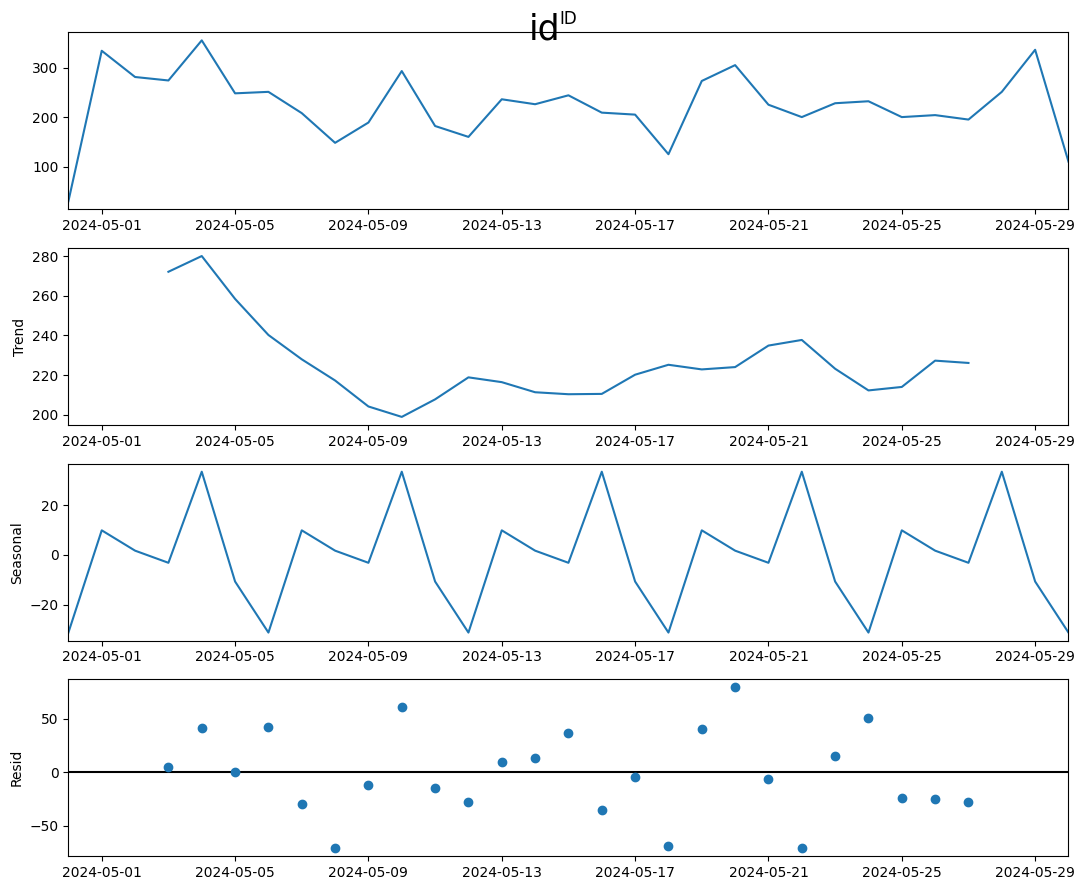

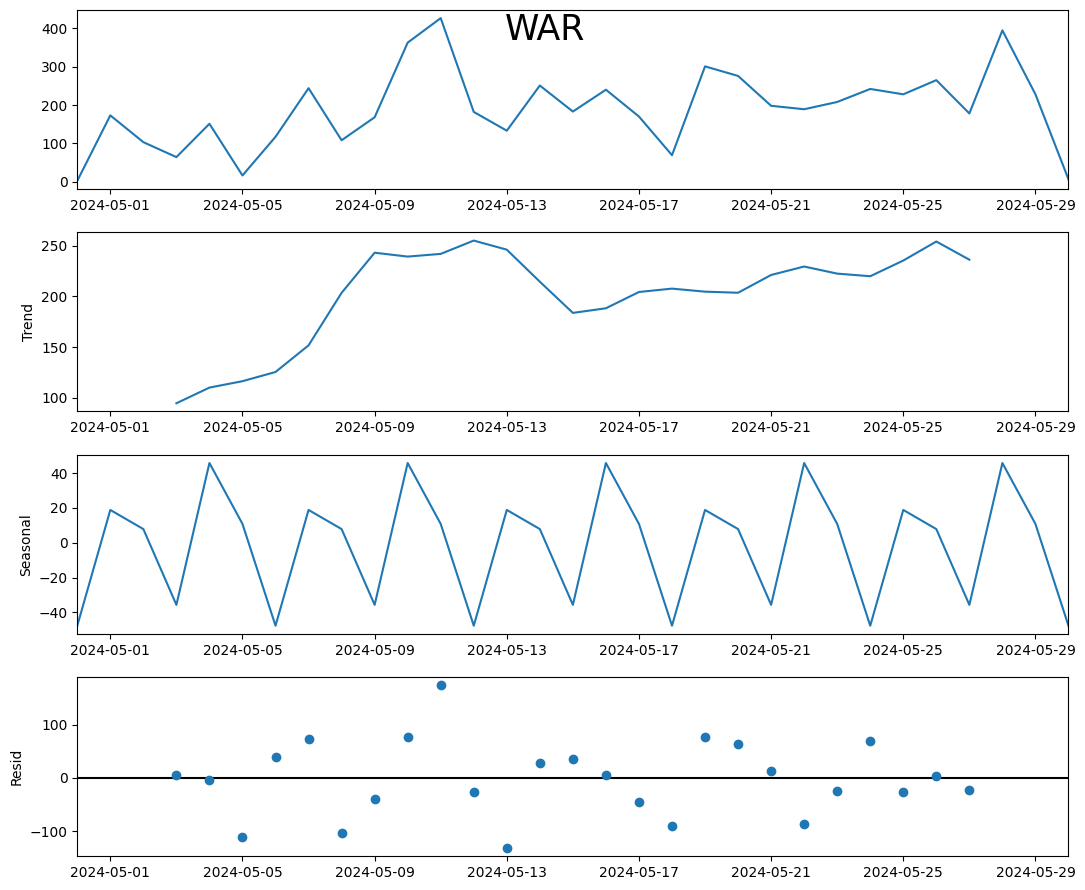

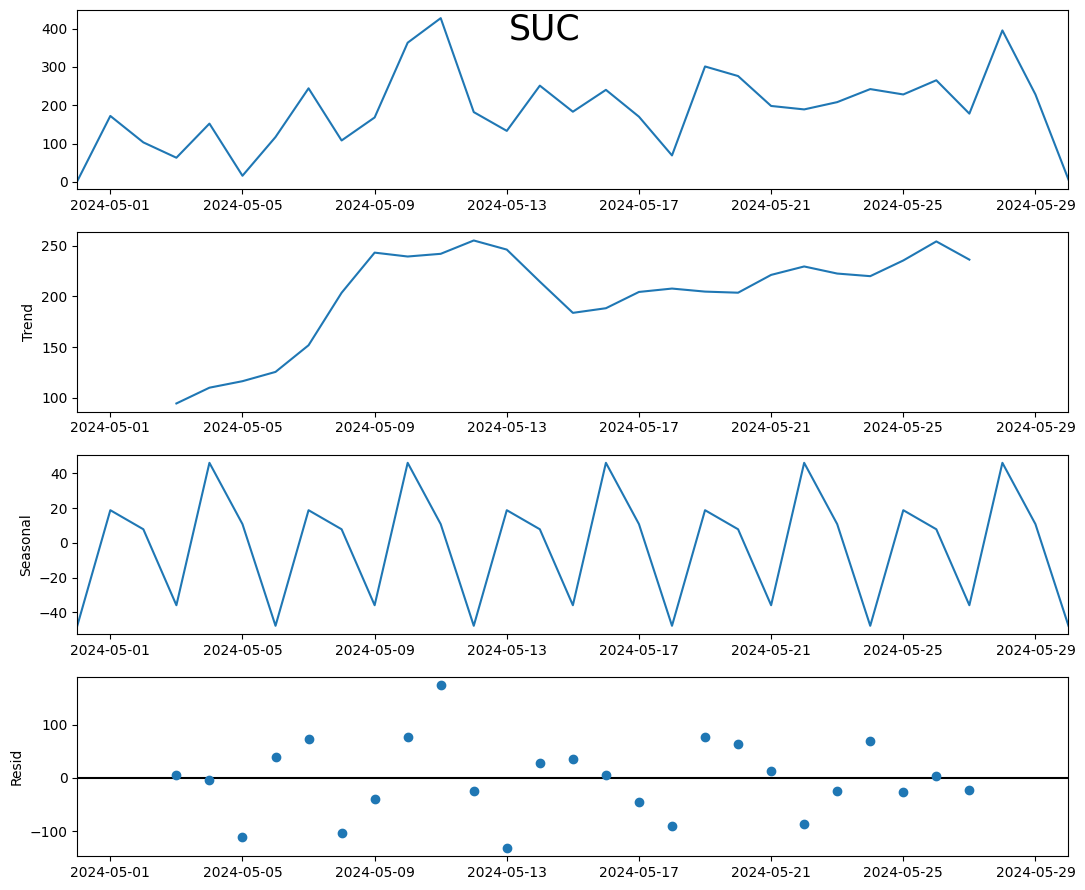

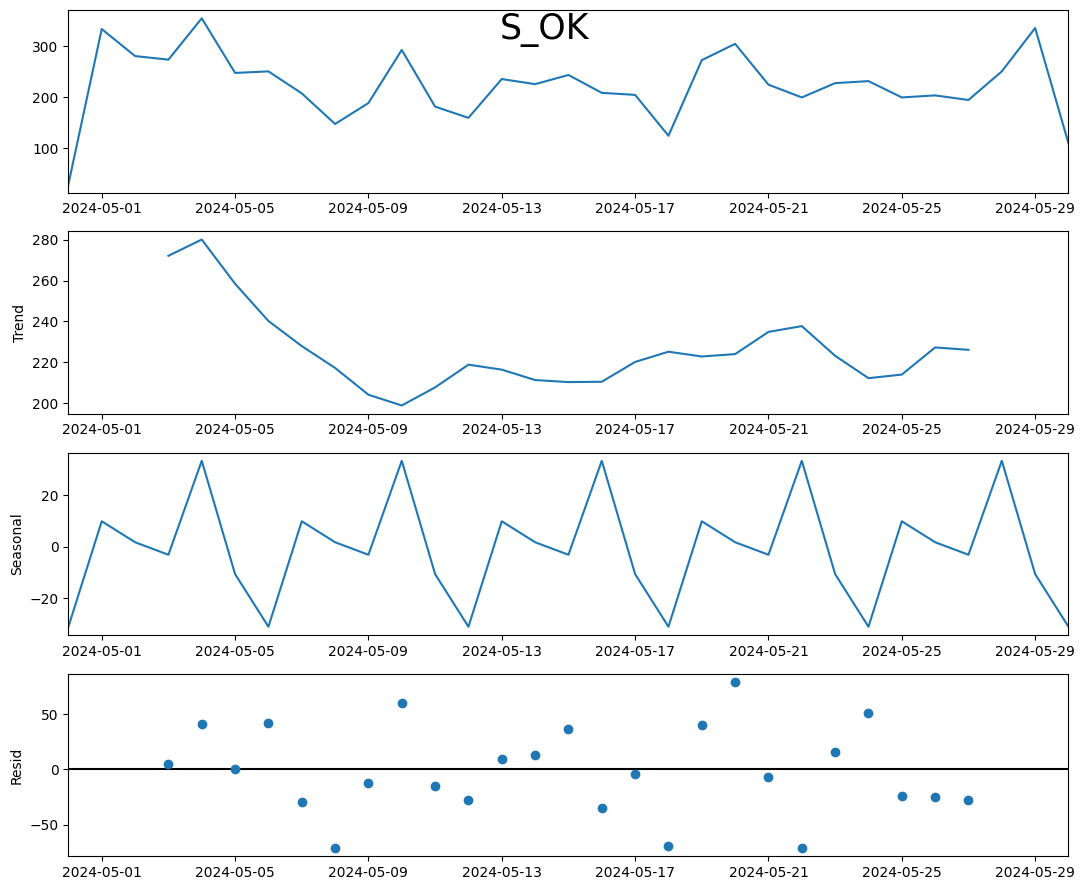

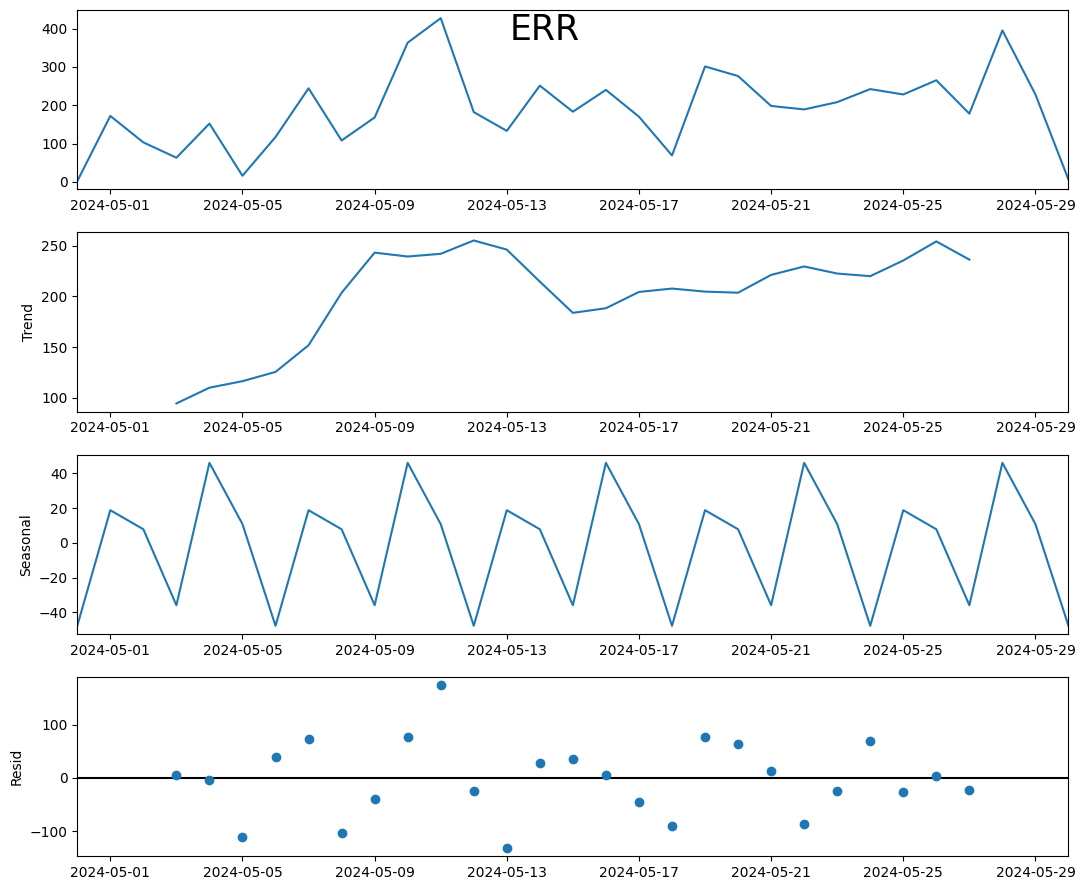

In [17]:

rcParams['figure.figsize'] = 11, 9 # Устанавливаем размер графика

for graf,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале

    decompose = seasonal_decompose(graf, period=6)# Выполняем сезонное разложение временного ряда graf с периодом 6
    fig = decompose.plot() # Создаем графическое представление разложения и сохраняем его в fig
    fig.suptitle(nameG, fontsize=25) #Устанавливаем заголовок 

    plt.show()# Отображаем график

Графики среднее скользящее среднее

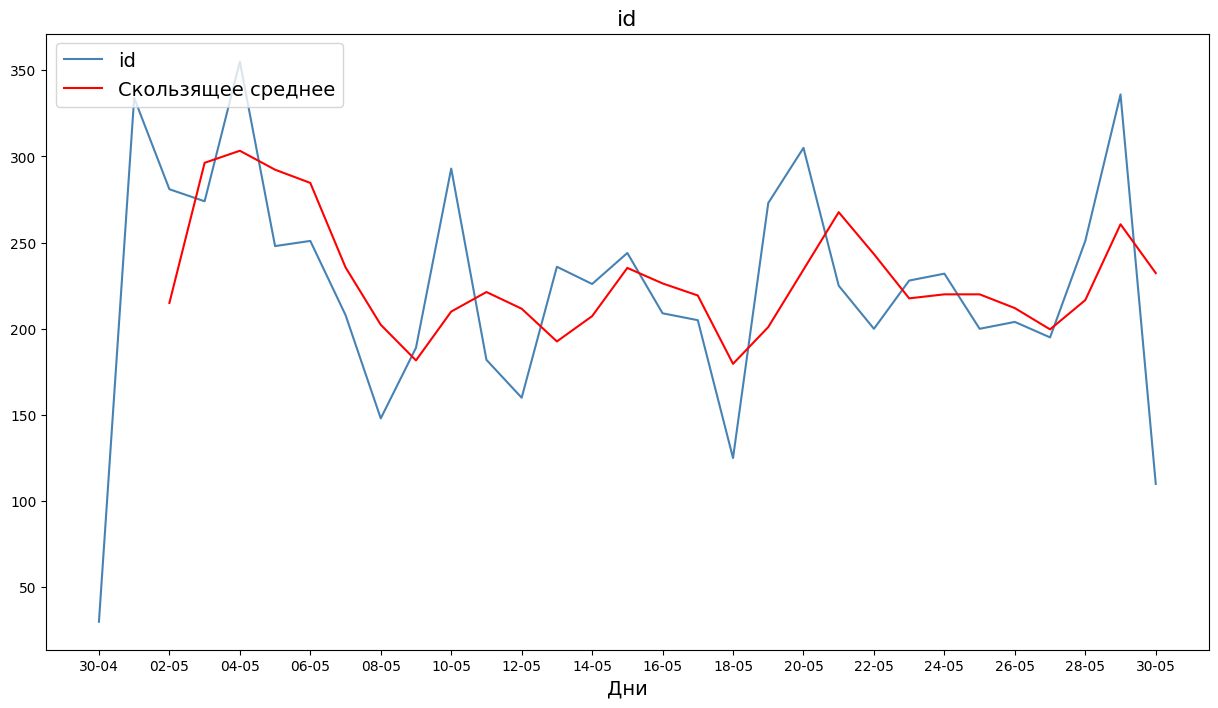

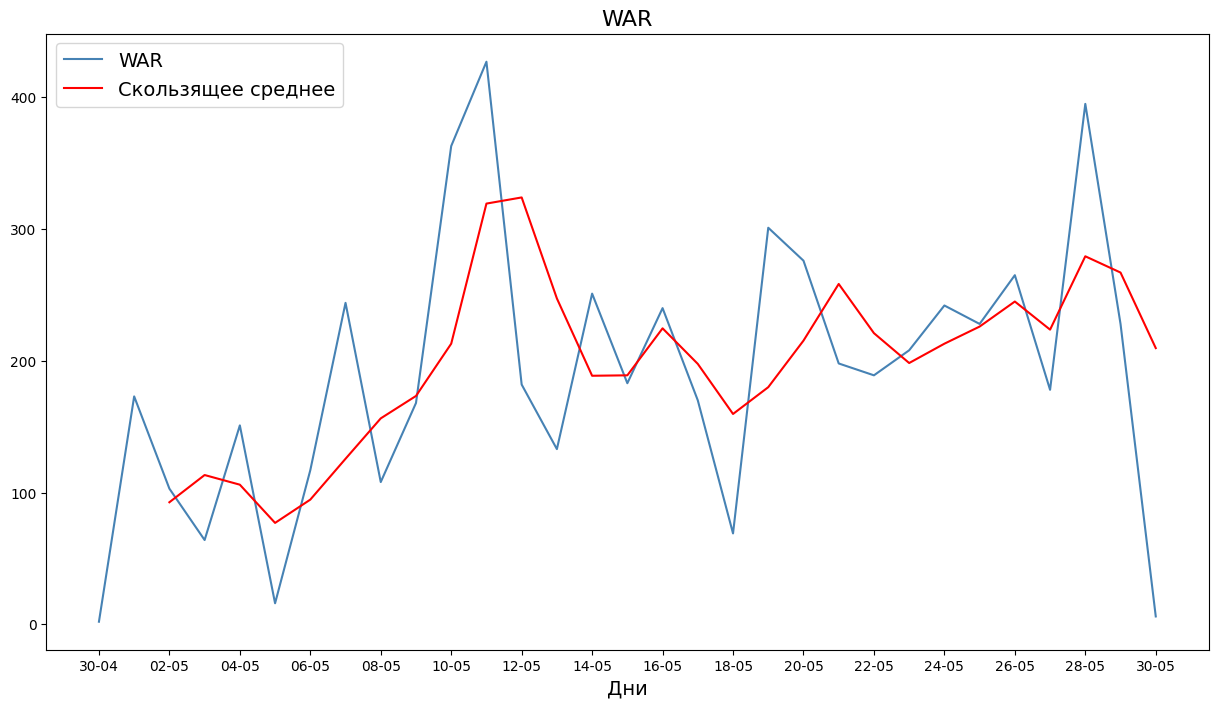

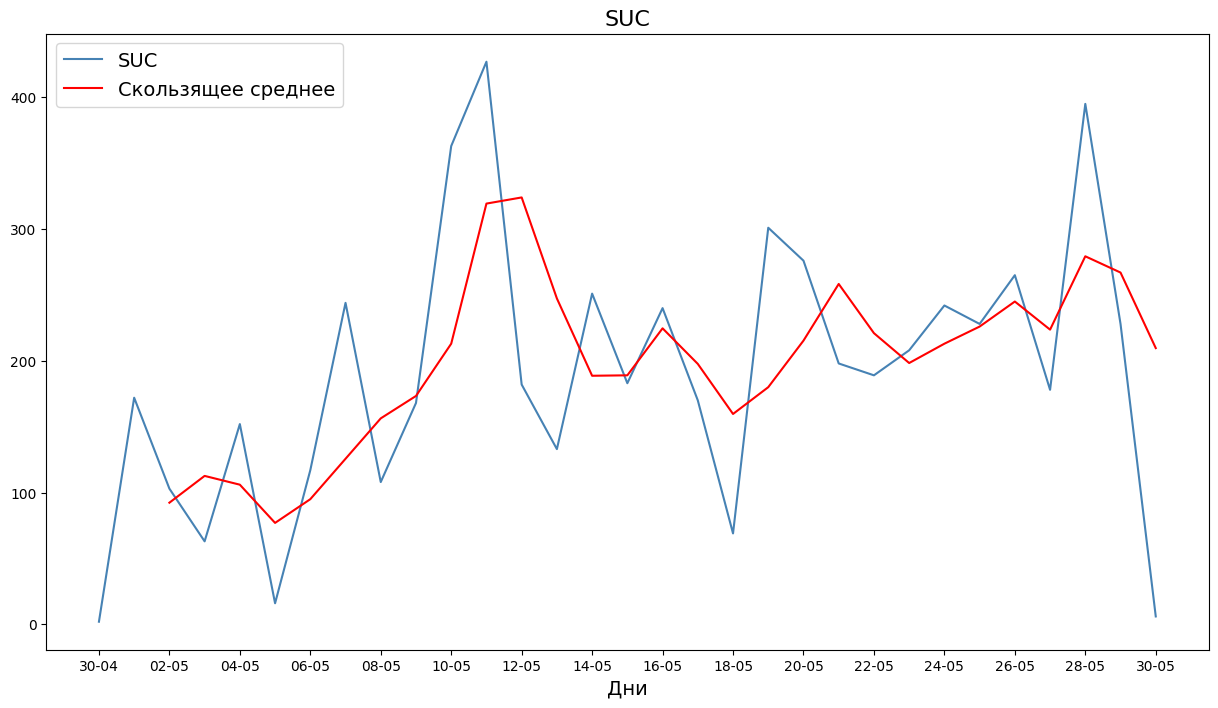

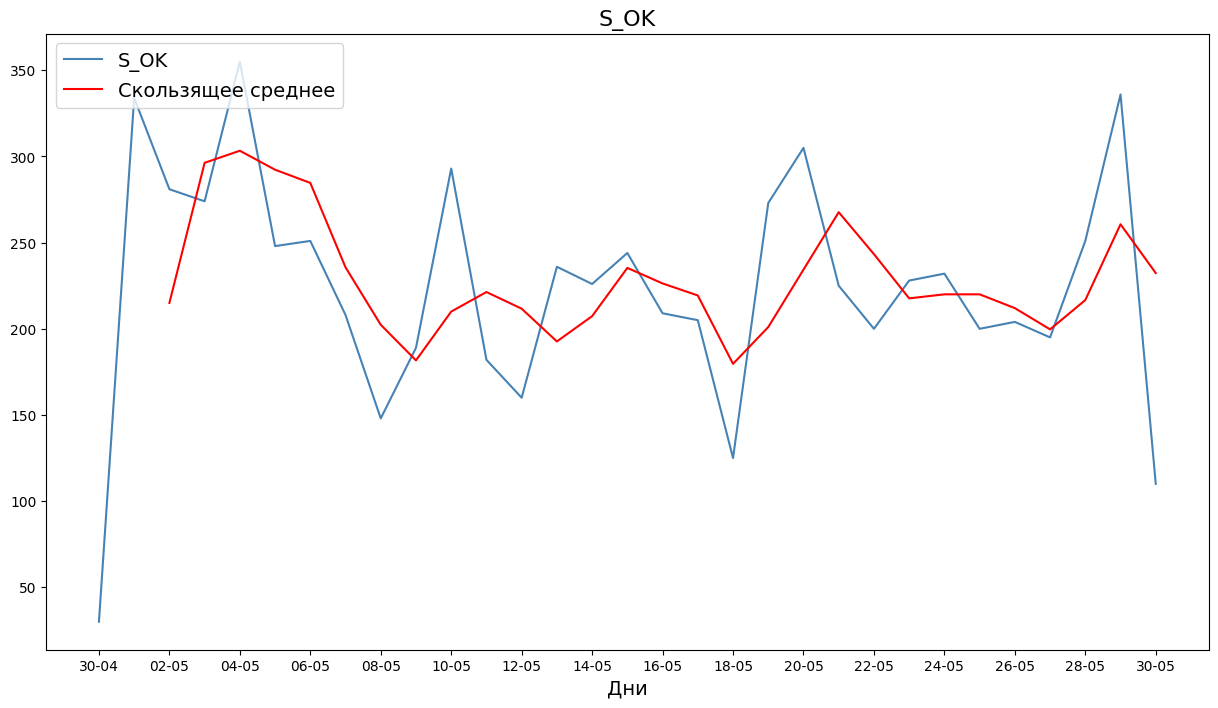

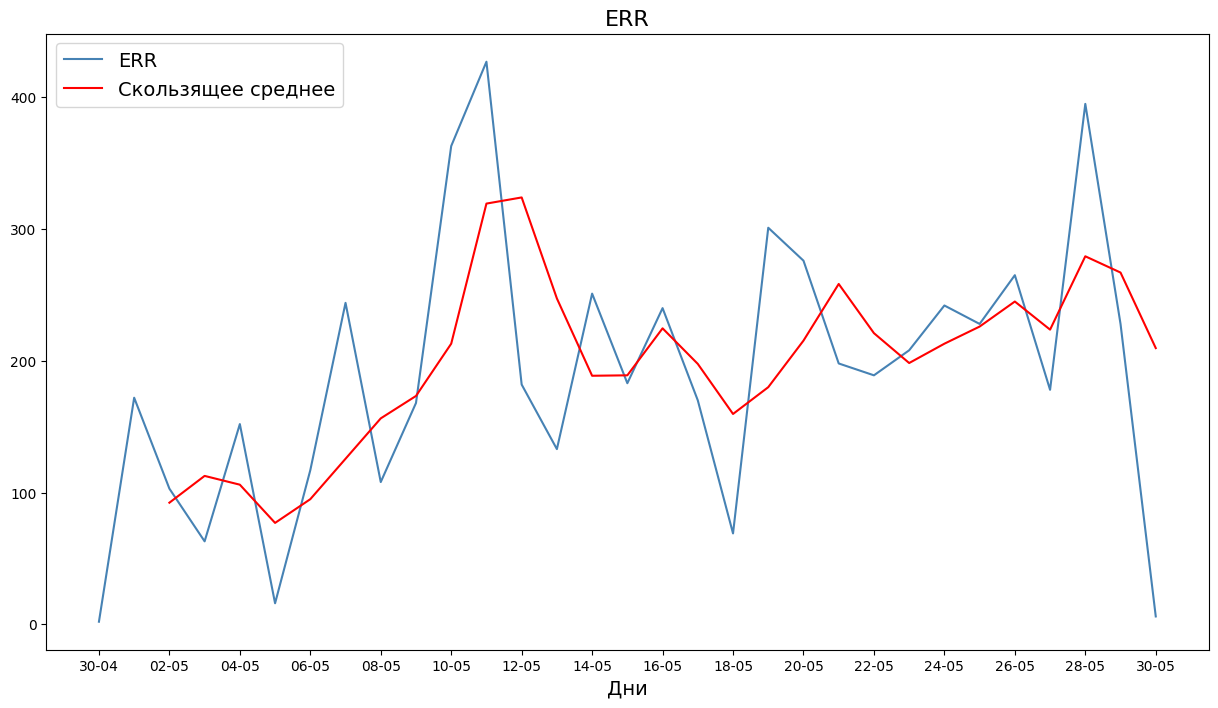

In [18]:
date_form = mdates.DateFormatter("%d-%m") # Устанавливаем формат даты для  графиков как "день-месяц"

for graf,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале
    plt.figure(figsize = (15,8))# Создаем новую фигуру размером 15 на 8 дюймов
    plt.gca().xaxis.set_major_formatter(date_form)# Устанавливаем форматтер оси X для текущего графика
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))# Устанавливаем локатор основных делений оси X с интервалом в 2 дня

   
    plt.plot(graf, label = nameG, color = 'steelblue')# Строим график временного ряда graf с меткой nameG и цветом steelblue
    plt.plot(graf.rolling(window = 3).mean(), label = 'Скользящее среднее', color = 'red')# Строим график скользящего среднего для временного ряда graf с окном шириной 3 и меткой 'Скользящее среднее', цветом red

    
    plt.legend(title = '', loc = 'upper left', fontsize = 14)# легенда

    
    plt.xlabel('Дни', fontsize = 14)# Устанавливаем название оси X как 'Дни' с шрифтом 14
    plt.title(nameG, fontsize = 16) # Устанавливаем заголовок

    # выведем обе кривые на одном графике
    plt.show()

Графики для АВТОКОРРЕЛЯЦИИ 

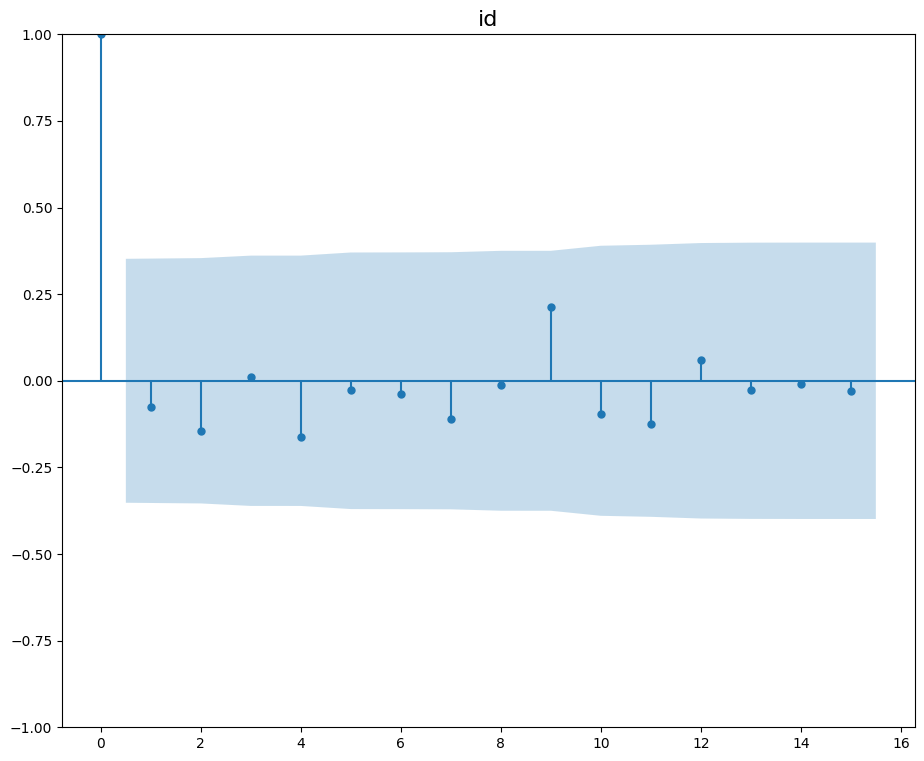

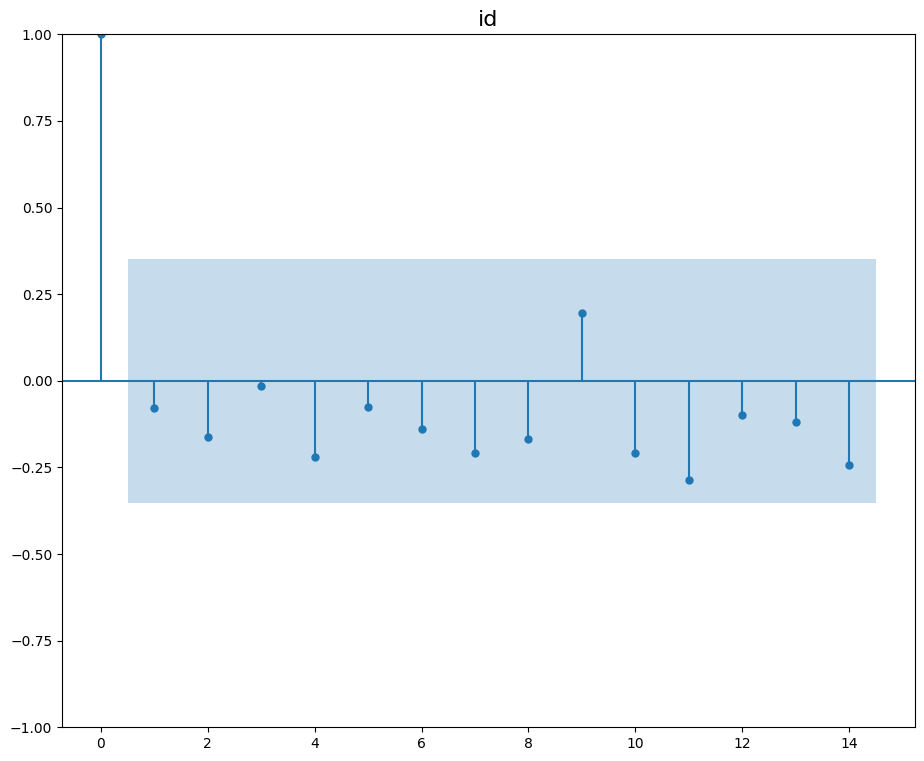

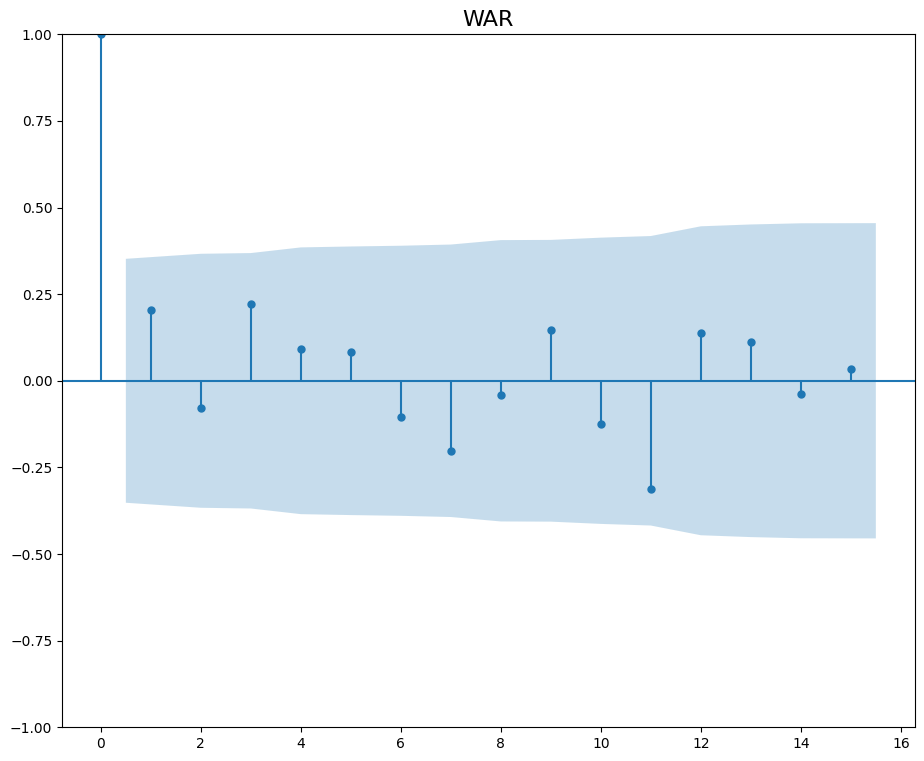

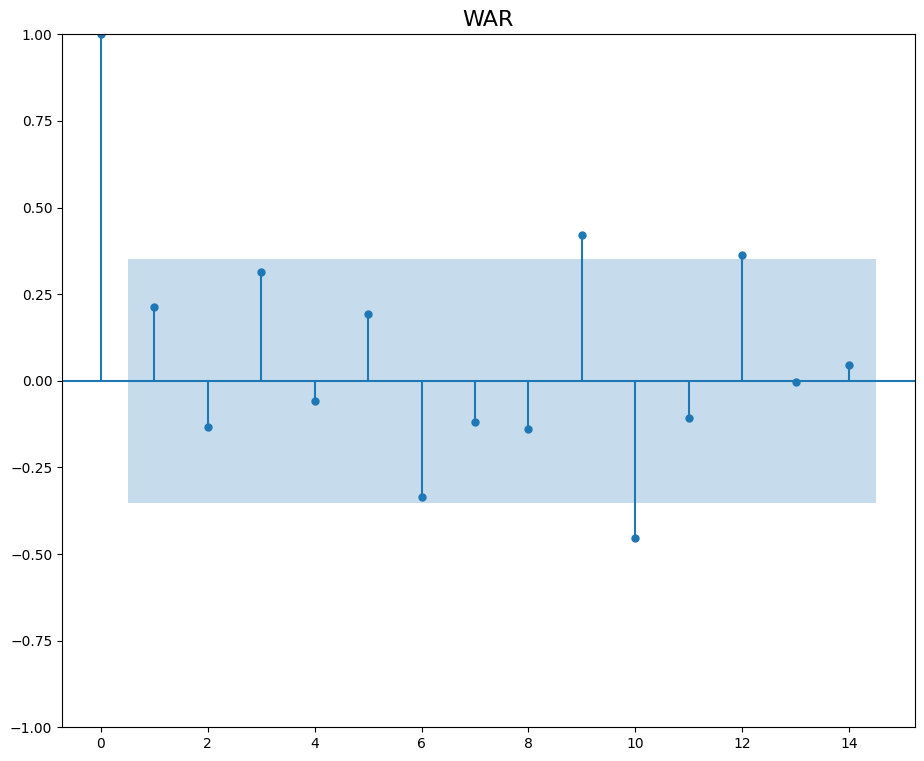

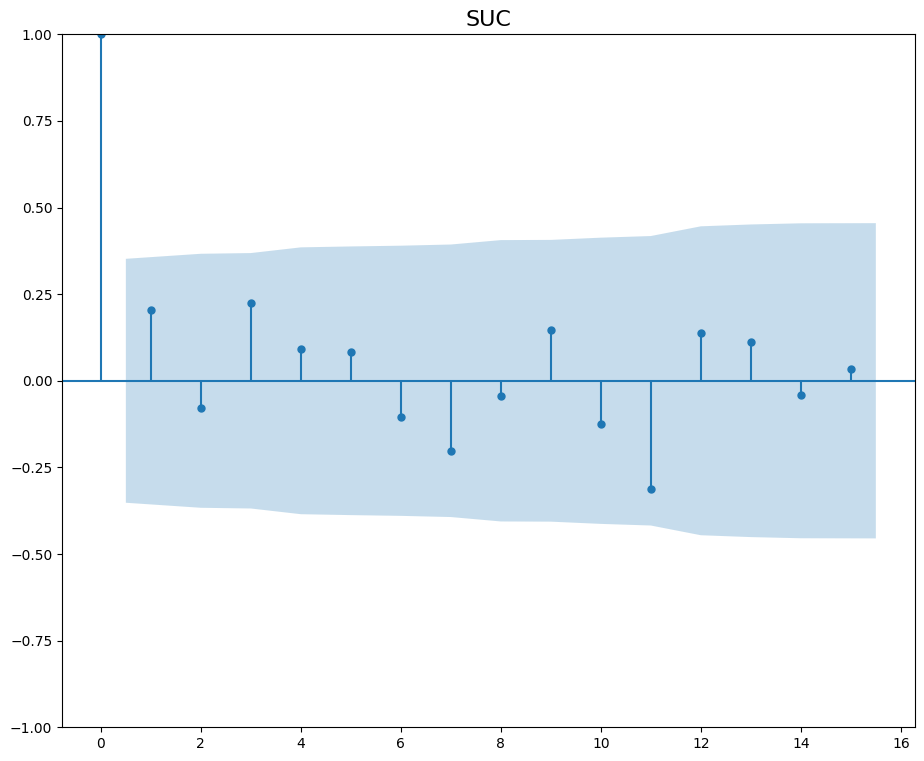

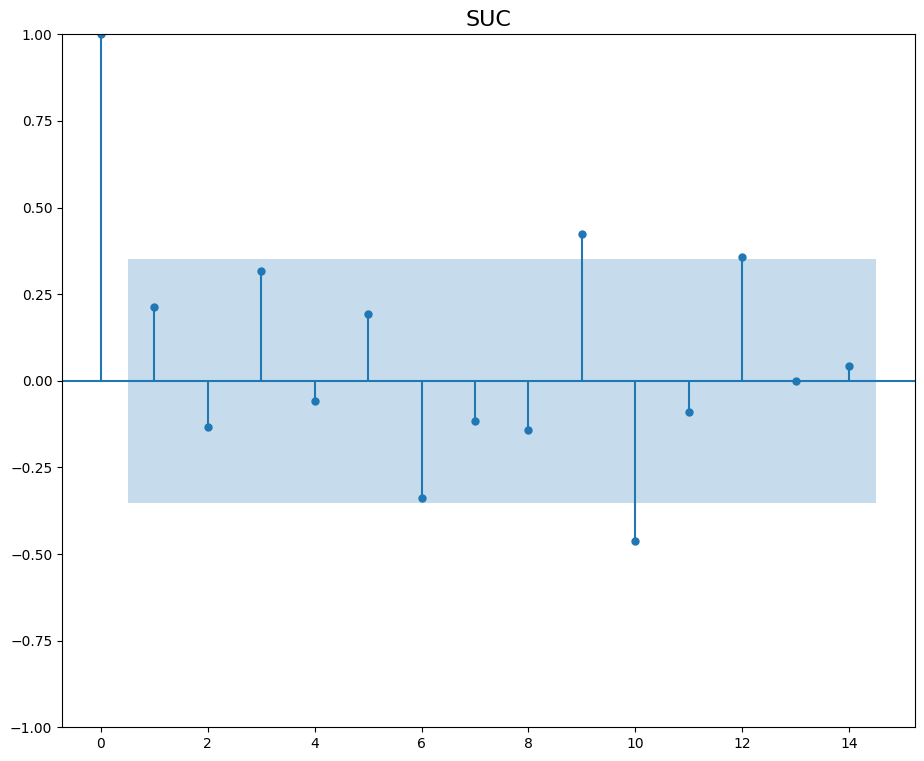

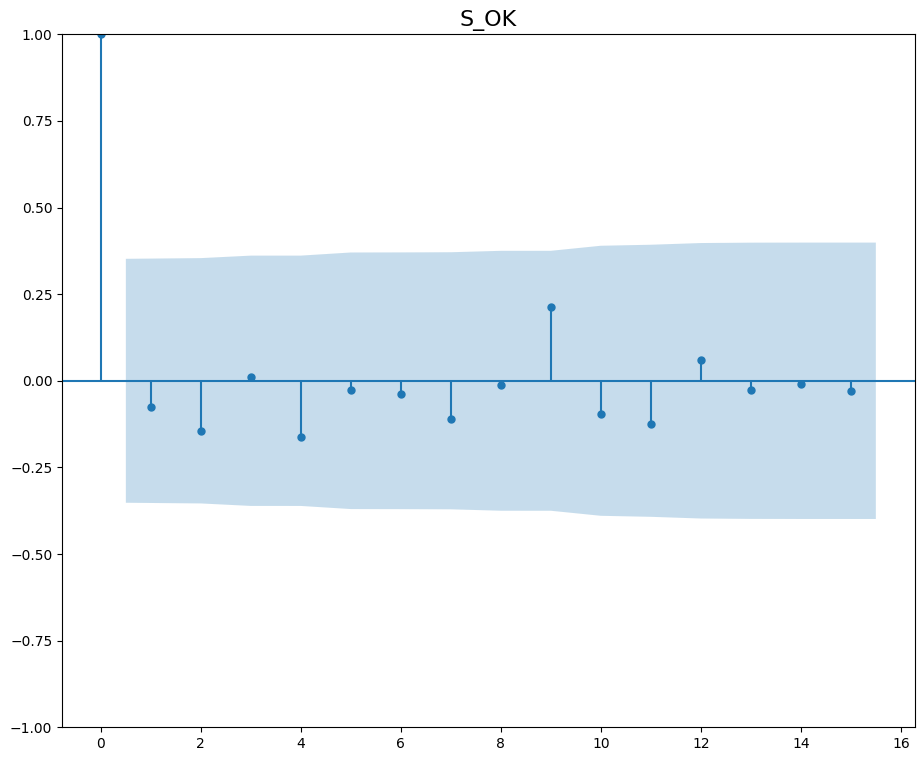

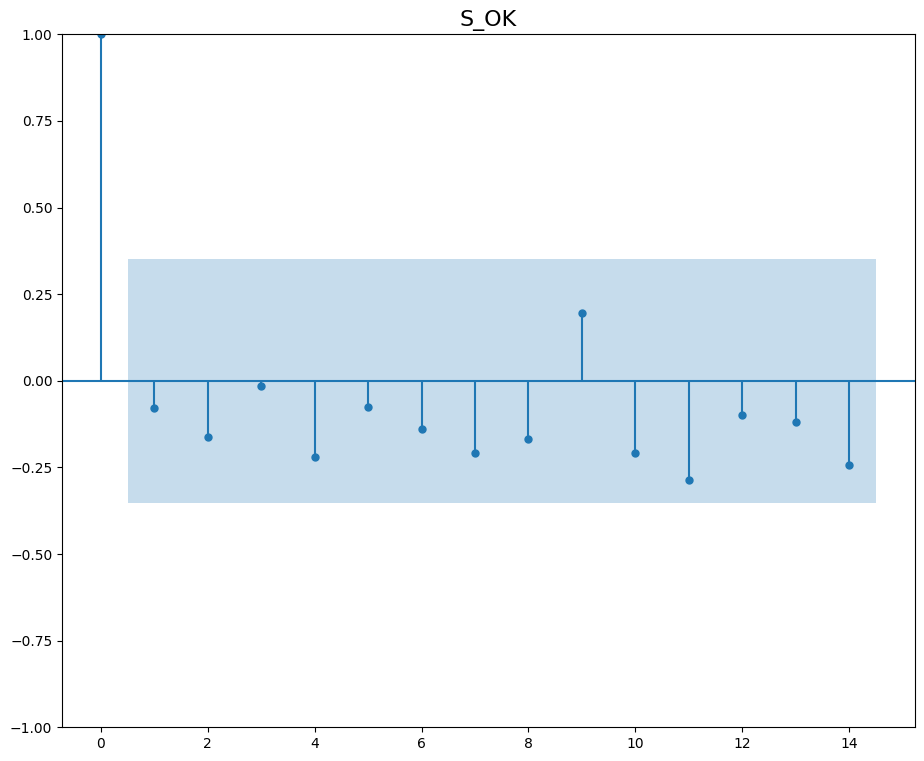

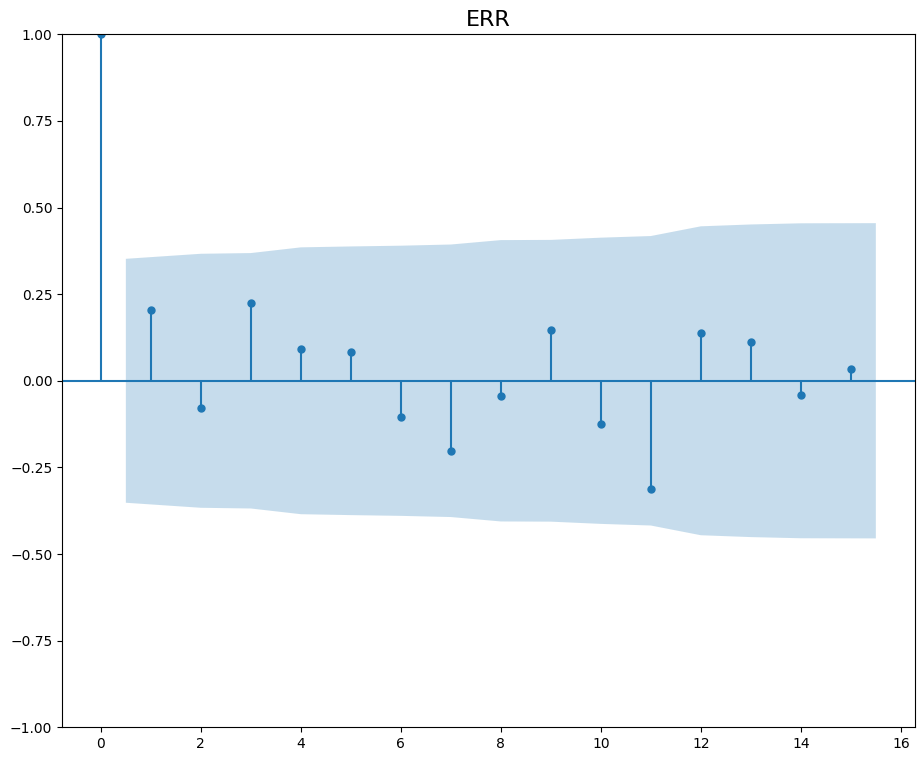

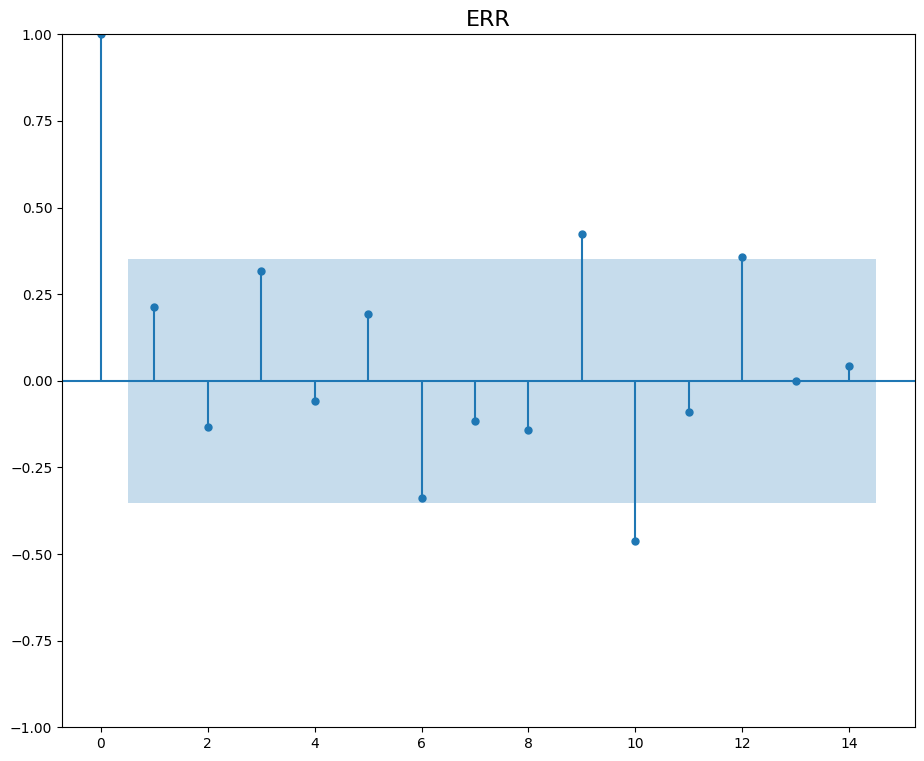

In [19]:
for graf,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале
    
    plot_acf(graf)# Строим автокорреляционную функцию
    plt.title(nameG, fontsize = 16)# Устанавливаем заголовок графика 
    plt.show()# Отображаем график
    
    plot_pacf(graf, lags=14)# Строим частичную автокорреляционную функцию
    plt.title(nameG, fontsize = 16)# Устанавливаем заголовок графика 
    plt.show()# Отображаем график

ПОДБОР ГИПЕРПАРАМЕТРОВ



ВЫбОР ФАЙЛА ДЛЯ ПОДБОРА ЛУЧШИХ ГИПЕРПАРАМЕТРОВ

In [20]:
#ID-0 WAR-1,SUC-2,SUC_OK-3,ERR-4

i=0

In [21]:

warnings.filterwarnings('ignore')# Игнорируем все предупреждения
warnings.filterwarnings("ignore", category=ConvergenceWarning)# Игнорируем предупреждения о сходимости
warnings.filterwarnings("ignore", category=UserWarning)# Игнорируем пользовательские предупреждения

data=allGr[i]#массив файлов в начале, Выбираем данные из массива allGr по индексу i


parameters = {'p': range(0, 22), 'd': range(0, 2), 'q': range(0, 22)}# Задаем параметры для подбора модели ARIMA

# Инициализируем списки для метрик
met_mse = []
met_mae = []
met_r2 = []
met_mape = []

def evaluate_arima(params):
    try:
        model = ARIMA(data, order=(params['p'], params['d'], params['q'])) # Создаем модель ARIMA с параметрами из params
        model.initialize_approximate_diffuse() # Инициализируем приближенную диффузию модели
        model_fit = model.fit()# Применяем модель к данным
        predictions = model_fit.forecast(steps=len(data)) # Делаем прогноз на длину данных data

        metric_mse = mean_squared_error(data, predictions, squared=False)# Вычисляем среднеквадратическую ошибку между данными и прогнозами
        metric_mae = mean_absolute_error(data, predictions) # Вычисляем среднюю абсолютную ошибку между данными и прогнозами
        metric_r2 = r2_score(data, predictions) # Вычисляем коэффициент детерминации между данными и прогнозами
        metric_mape = mean_absolute_percentage_error(data, predictions)# Вычисляем среднюю абсолютную процентную ошибку между данными и прогнозами

        return (params, metric_mse, metric_mae, metric_r2, metric_mape) #Возвращаем параметры и вычисленные метрики
    except:
        return None # Если возникла ошибка, возвращаем None




Подбор лучших гиперпараметров

In [22]:


results = Parallel(n_jobs=-1)(delayed(evaluate_arima)(params) for params in ParameterGrid(parameters))# Используем параллельное выполнение для оценки моделей ARIMA с различными параметрами из ParameterGrid(parameters)


results = [result for result in results if result is not None]# Фильтруем результаты, исключая неудачные (None)


for result in results: # Разделение результатов по метрикам
    params, metric_mse, metric_mae, metric_r2, metric_mape = result
    met_mse.append((params, metric_mse))# Добавляем параметры и метрику MSE в список
    met_mae.append((params, metric_mae)) # Добавляем параметры и метрику MAE в список
    met_r2.append((params, metric_r2)) # Добавляем параметры и метрику R2 в список
    met_mape.append((params, metric_mape)) # Добавляем параметры и метрику MAPE в список

print(f'MAPE: {min(met_mape, key=lambda x: x[1])}')#Вывод результа MAPE
print(f'R2: {max(met_r2, key=lambda x: x[1])}')#Вывод результа R2
print(f'MSE: {min(met_mse, key=lambda x: x[1])}')#Вывод результа MSE
print(f'MAE: {min(met_mae, key=lambda x: x[1])}')#Вывод результа MAE



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in 

MAPE: ({'d': 0, 'p': 4, 'q': 13}, 0.26953388521952937)
R2: ({'d': 0, 'p': 21, 'q': 5}, 0.39537716095037945)
MSE: ({'d': 0, 'p': 21, 'q': 5}, 52.34114812822058)
MAE: ({'d': 0, 'p': 21, 'q': 5}, 40.361072540058785)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ ВСЕХ ФАЙЛОВ СРАЗУ


In [23]:
'''
warnings.filterwarnings('ignore')# Игнорируем все предупреждения
warnings.filterwarnings("ignore", category=ConvergenceWarning)# Игнорируем предупреждения о сходимости
warnings.filterwarnings("ignore", category=UserWarning)# Игнорируем пользовательские предупреждения

for data,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале

    
    

    parameters = {'p': range(0, 22), 'd': range(0, 2), 'q': range(0, 22)}# Задаем параметры для подбора модели ARIMA

    # Инициализируем списки для метрик
    met_mse = []
    met_mae = []
    met_r2 = []
    met_mape = []

    def evaluate_arima(params):
        try:
            model = ARIMA(data, order=(params['p'], params['d'], params['q'])) # Создаем модель ARIMA с параметрами из params
            model.initialize_approximate_diffuse() # Инициализируем приближенную диффузию модели
            model_fit = model.fit()# Применяем модель к данным
            predictions = model_fit.forecast(steps=len(data)) # Делаем прогноз на длину данных data

            metric_mse = mean_squared_error(data, predictions, squared=False)# Вычисляем среднеквадратическую ошибку между данными и прогнозами
            metric_mae = mean_absolute_error(data, predictions) # Вычисляем среднюю абсолютную ошибку между данными и прогнозами
            metric_r2 = r2_score(data, predictions) # Вычисляем коэффициент детерминации между данными и прогнозами
            metric_mape = mean_absolute_percentage_error(data, predictions)# Вычисляем среднюю абсолютную процентную ошибку между данными и прогнозами

            return (params, metric_mse, metric_mae, metric_r2, metric_mape) #Возвращаем параметры и вычисленные метрики
        except:
            return None # Если возникла ошибка, возвращаем None

    
            
    results = Parallel(n_jobs=-1)(delayed(evaluate_arima)(params) for params in ParameterGrid(parameters))# Используем параллельное выполнение для оценки моделей ARIMA с различными параметрами из ParameterGrid(parameters)


    results = [result for result in results if result is not None]# Фильтруем результаты, исключая неудачные (None)


    for result in results: # Разделение результатов по метрикам
        params, metric_mse, metric_mae, metric_r2, metric_mape = result
        met_mse.append((params, metric_mse))# Добавляем параметры и метрику MSE в список
        met_mae.append((params, metric_mae)) # Добавляем параметры и метрику MAE в список
        met_r2.append((params, metric_r2)) # Добавляем параметры и метрику R2 в список
        met_mape.append((params, metric_mape)) # Добавляем параметры и метрику MAPE в список

    print(f'MAPE: {min(met_mape, key=lambda x: x[1])}')#Вывод результа MAPE
    print(f'R2: {max(met_r2, key=lambda x: x[1])}')#Вывод результа R2
    print(f'MSE: {min(met_mse, key=lambda x: x[1])}')#Вывод результа MSE
    print(f'MAE: {min(met_mae, key=lambda x: x[1])}')#Вывод результа MAE


'''

'\nwarnings.filterwarnings(\'ignore\')# Игнорируем все предупреждения\nwarnings.filterwarnings("ignore", category=ConvergenceWarning)# Игнорируем предупреждения о сходимости\nwarnings.filterwarnings("ignore", category=UserWarning)# Игнорируем пользовательские предупреждения\n\nfor data,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале\n\n    \n    \n\n    parameters = {\'p\': range(0, 22), \'d\': range(0, 2), \'q\': range(0, 22)}# Задаем параметры для подбора модели ARIMA\n\n    # Инициализируем списки для метрик\n    met_mse = []\n    met_mae = []\n    met_r2 = []\n    met_mape = []\n\n    def evaluate_arima(params):\n        try:\n            model = ARIMA(data, order=(params[\'p\'], params[\'d\'], params[\'q\'])) # Создаем модель ARIMA с параметрами из params\n            model.initialize_approximate_diffuse() # Инициализируем приближенную диффузию модели\n            model_fit = model.fit()# Применяем модель к данным\n            predictions = model_fit.forec

БЛОК ОБУЧЕНИЯ МОДЕЛИ

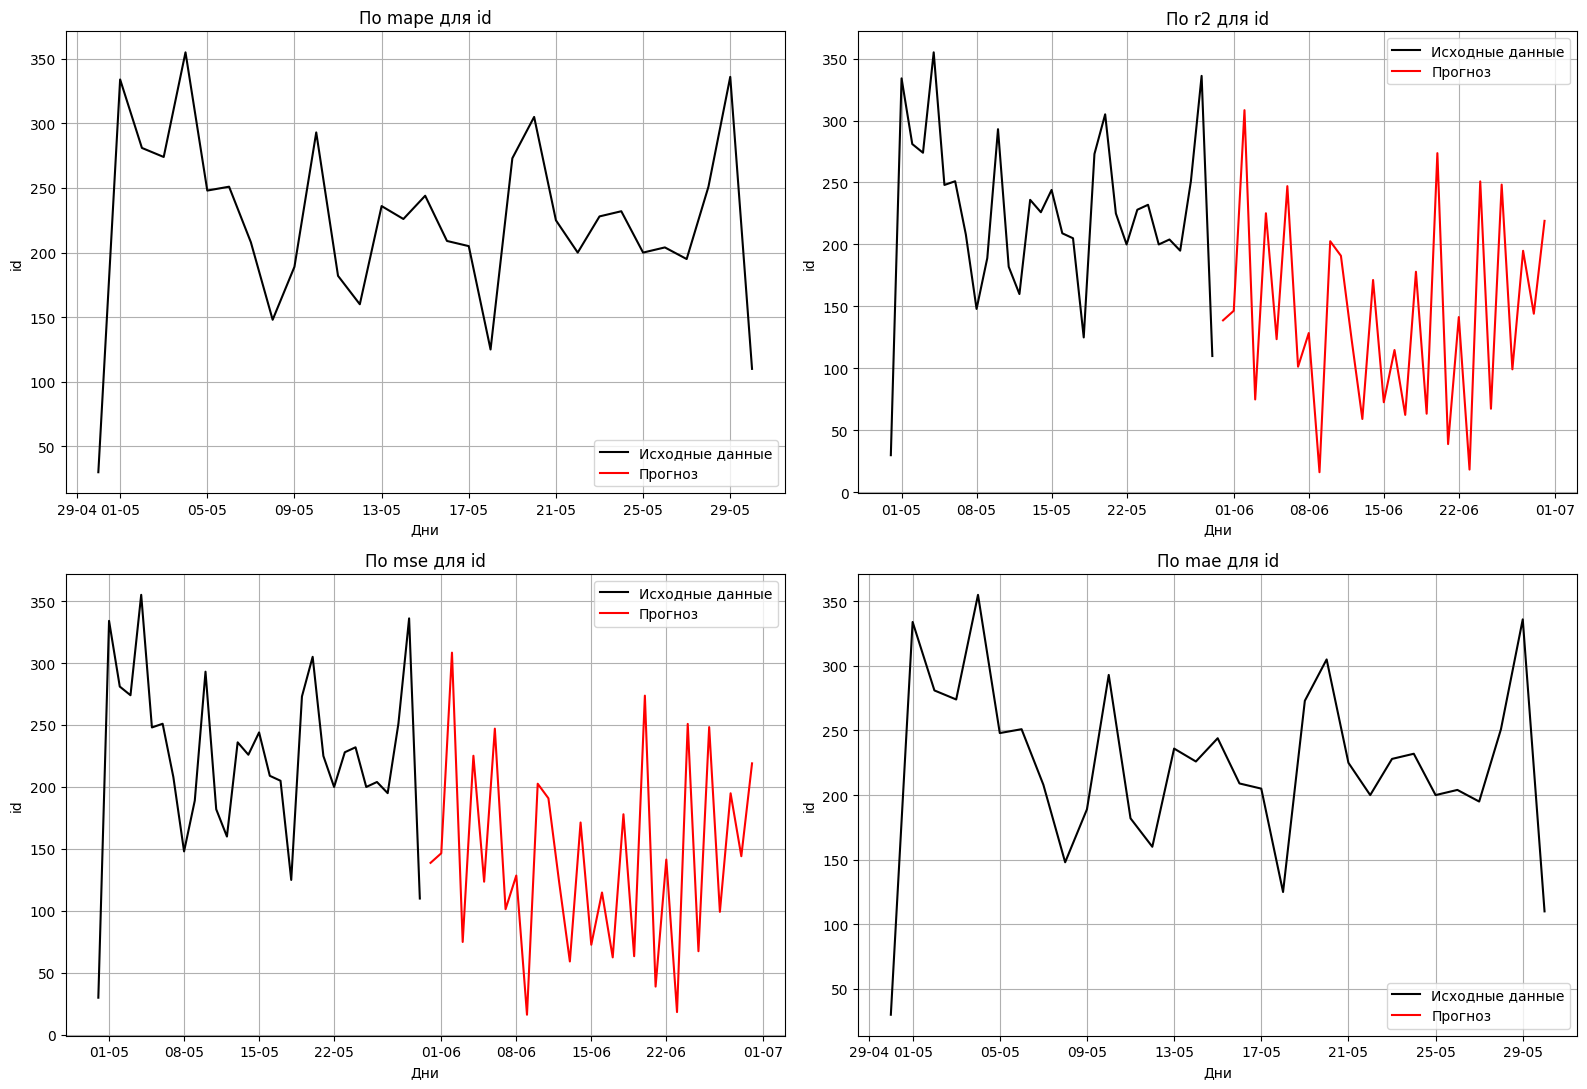

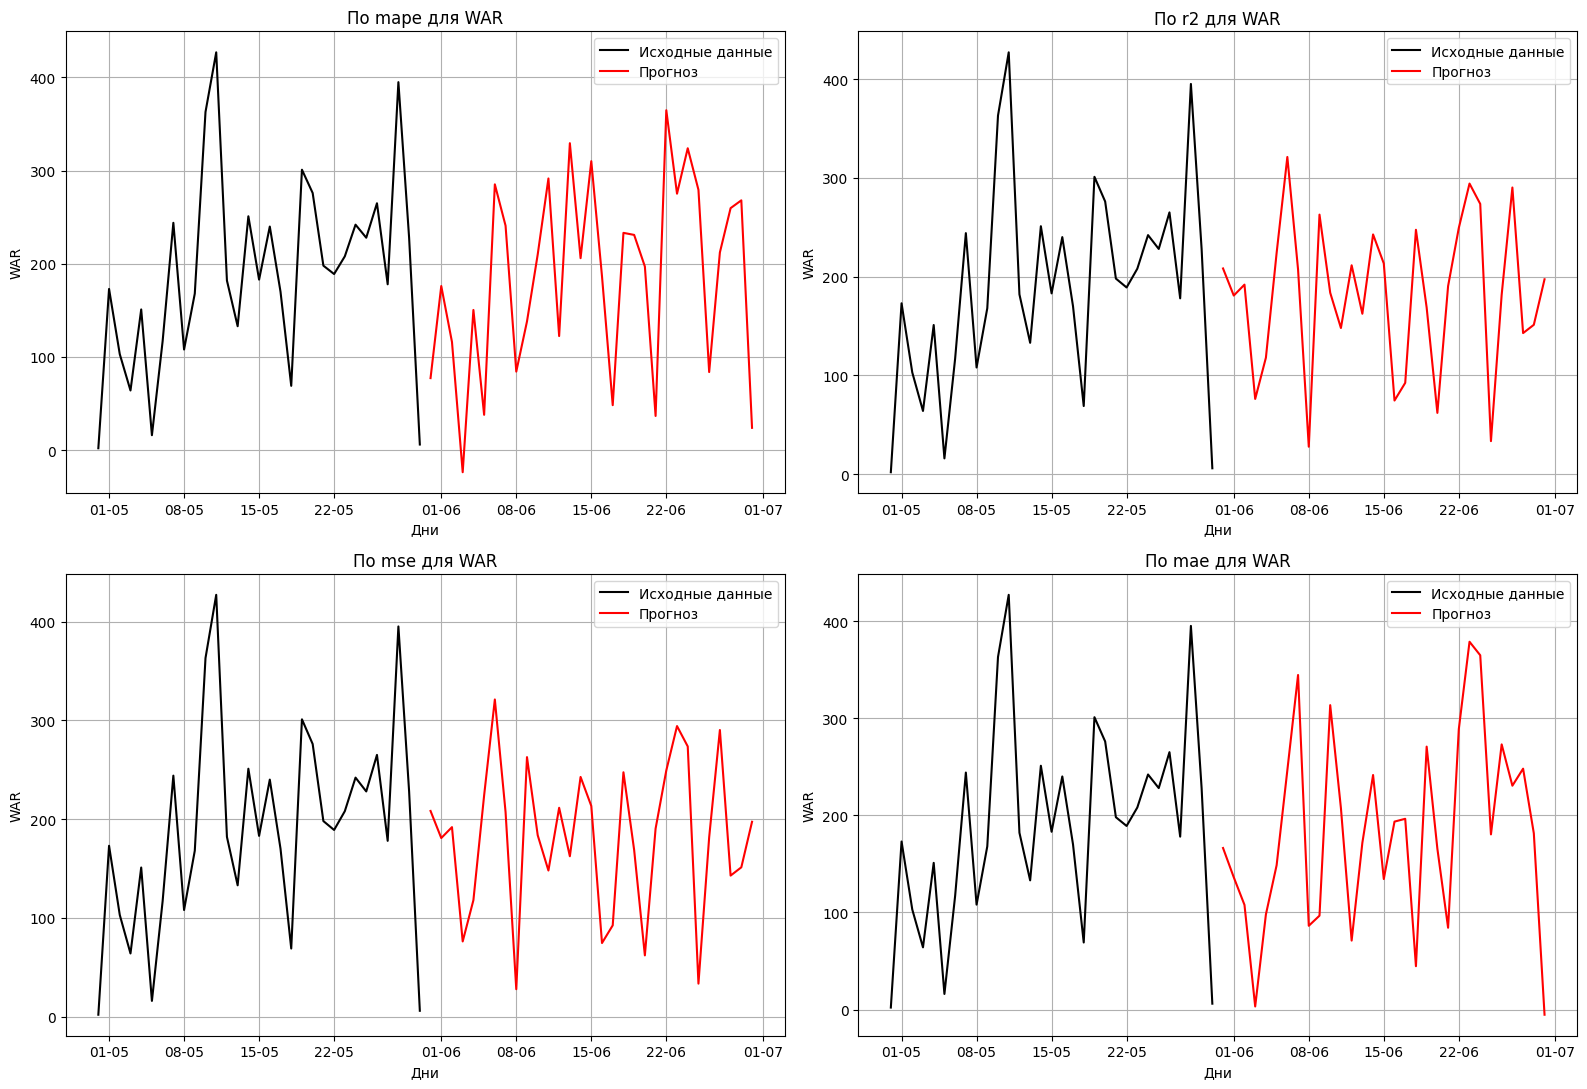

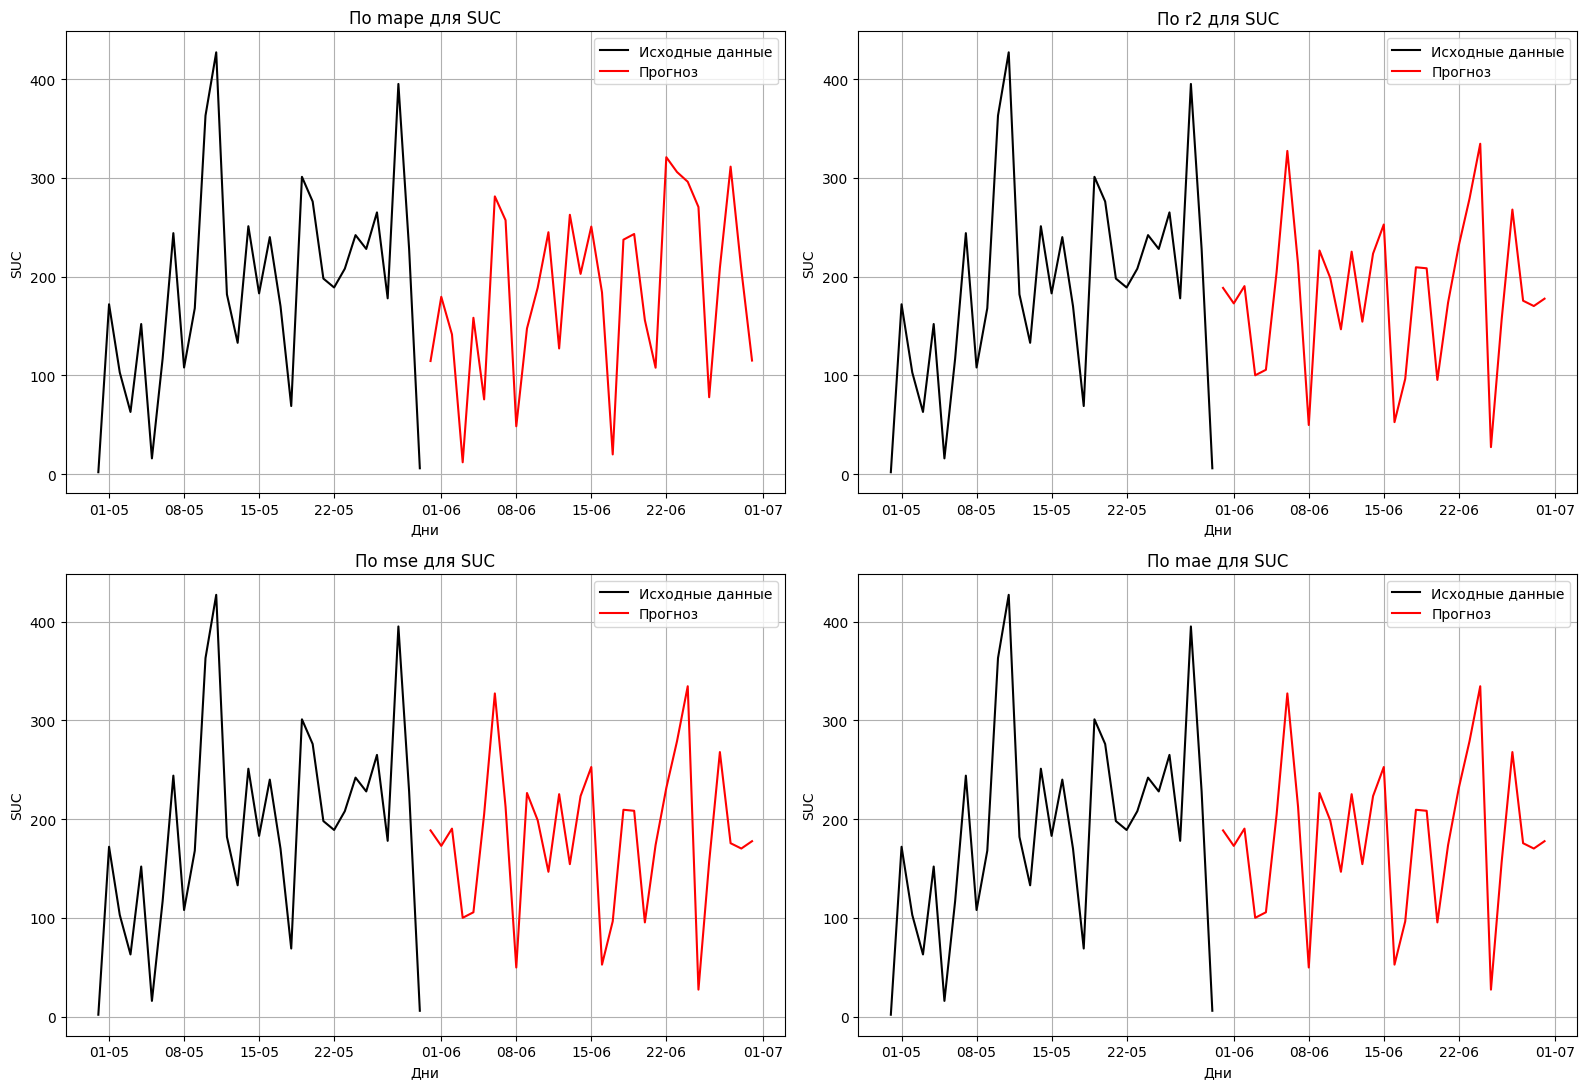

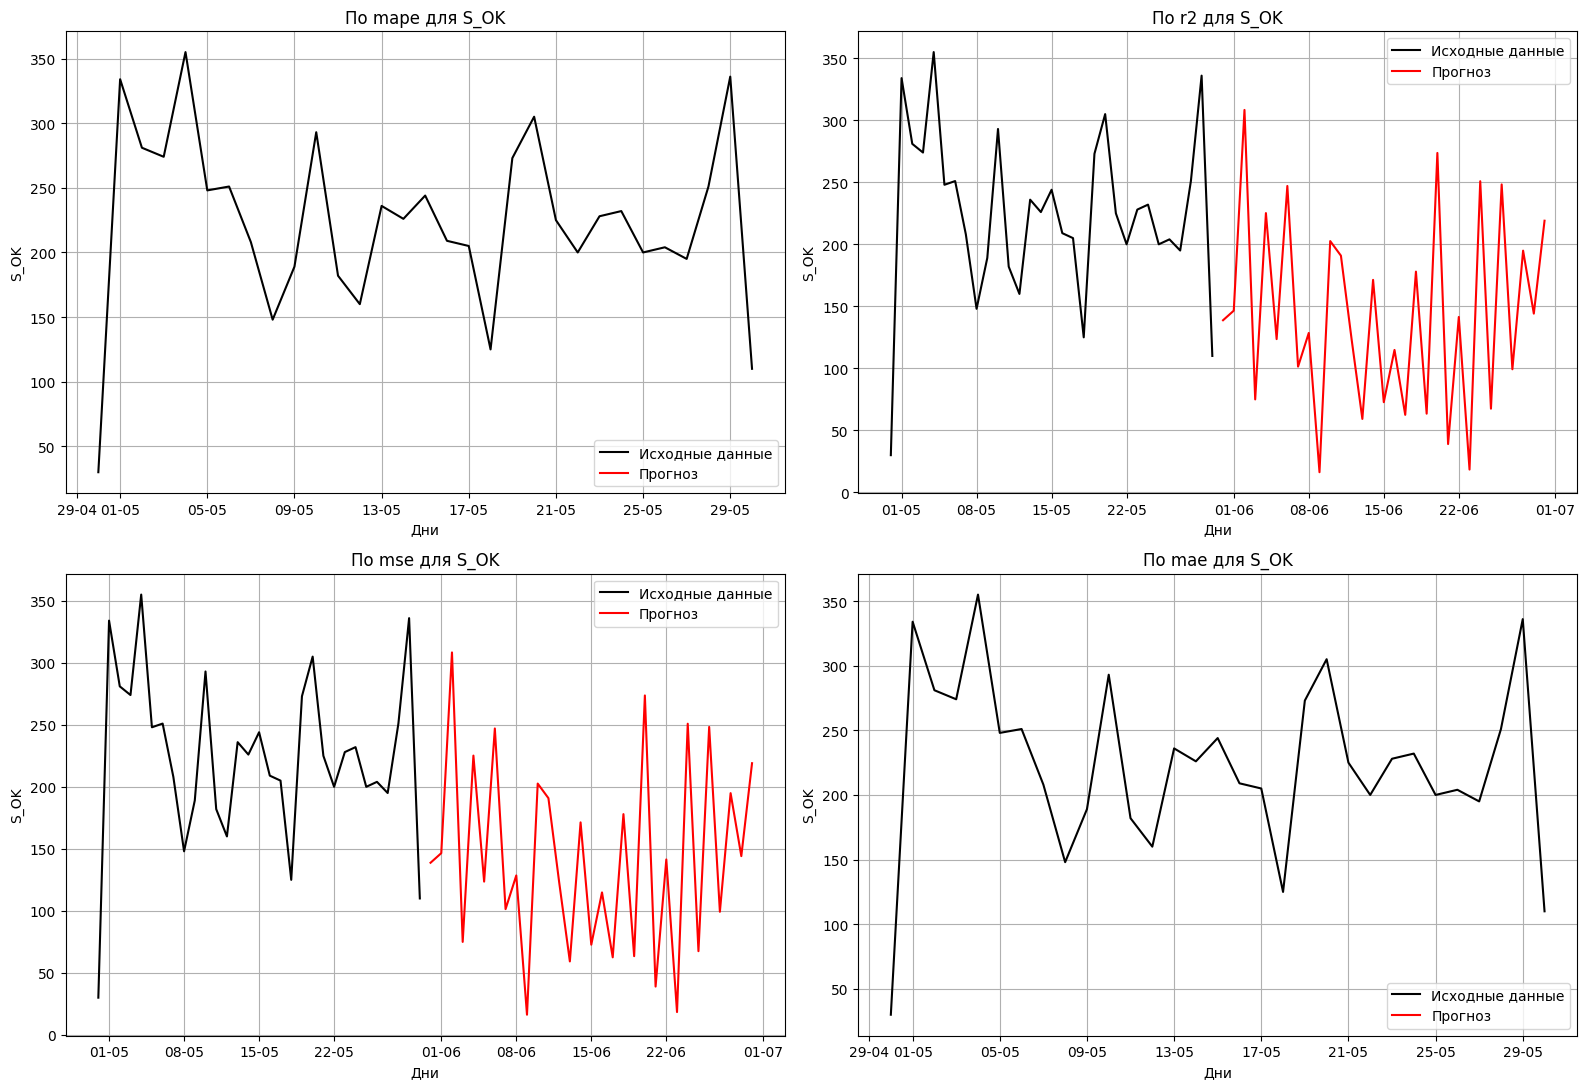

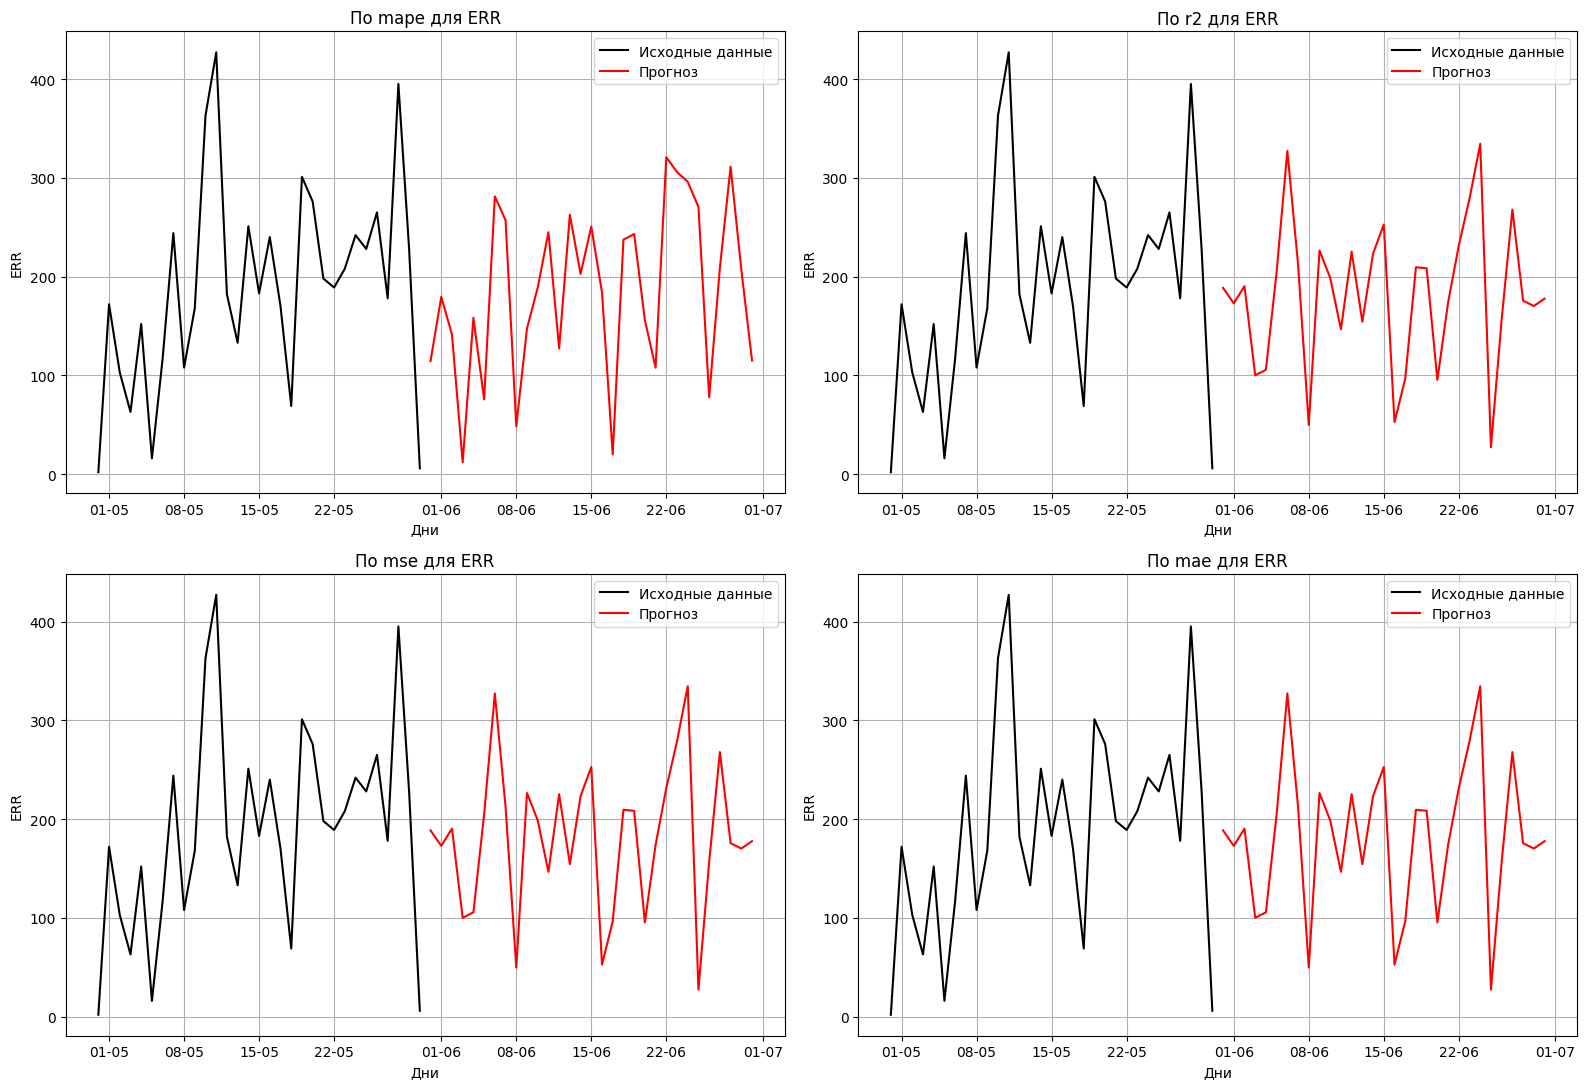

In [24]:


# Создаем список наборов параметров
orders_dict = {
    'id': [(18, 0, 9), (19, 1, 19),(19, 1, 19), (18, 0, 9)],
    'WAR': [(20, 0, 1), (20, 0, 14), (20, 0, 14), (21, 0, 11)], 
    'SUC': [(20, 0, 2), (20, 0, 11), (20, 0, 11), (20, 0, 11)],  
    'S_OK': [(18, 0, 9), (19, 1, 19), (19, 1, 19), (18, 0, 9)],  
    'ERR': [(20, 0, 2), (20, 0, 11), (20, 0, 11), (20, 0, 11)],  
}
#массив имен
name=["mape","r2","mse","mae"]
 





for graf,nameG in zip(allGr,nameGr):#данные берутся из заданных массивов в начале
    warnings.simplefilter(action='ignore', category=Warning) # Игнорируем все предупреждения
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 11))# Создаем графическую фигуру с 4 подграфиками (2x2) размером 16x11 
   
    num_points = graf.shape[0] #Количество точек на графике
    
    orders = orders_dict[nameG]#Выбор набора данных
    # Итерируемся по каждому набору параметров и строим графики
    for i, order in enumerate(orders):
        
        model = ARIMA(graf, order=order)# Создаем модель ARIMA с заданными порядком и данными  
        model.initialize_approximate_diffuse()# Инициализируем приближенные диффузные значения
        result = model.fit()# Обучение модели и получение результатов

        
        forecast_periods = num_points# прогнозируем на заданное число дней вперед (равно кол-во исходных данных для прогноза)
        
        predictions = result.predict(start=len(graf), end=len(graf) + forecast_periods - 1)# Прогнозируем результаты

        # Генерация диапазона дат для прогнозов
        date_range = pd.date_range(start=graf.index[-1], periods=forecast_periods+1 , freq='D')[1:]
        predictions.index = date_range# Индексируем прогнозы по дате
        
        # Строим график
        row = i // 2
        col = i % 2
        axes[row, col].plot(graf, label='Исходные данные', color='black')# Строим график исходных данных
        axes[row, col].plot(predictions, label='Прогноз', color='red')# Строим график прогноза
        axes[row, col].set_title(f'По {name[i]} для {nameG}')# Устанавливаем заголовок графика
        axes[row, col].set_ylabel(nameG)# Устанавливаем подпись оси Y
        axes[row, col].set_xlabel('Дни')# Устанавливаем подпись оси X
        axes[row, col].legend() # Добавляем легенду
        axes[row, col].grid() # Включаем сетку на графике
        date_form = mdates.DateFormatter("%d-%m")# Устанавливаем формат даты для оси X
        axes[row, col].xaxis.set_major_formatter(date_form)# Применяем установленный формат даты к оси X
        
       
        
        '''
        # Расчет общих метрик
        mse = mean_squared_error(graf, predictions, squared=False) # squared=False - означает, что мы используем именно RMSE, а не MSE (squared=True параметр по умолчанию)
        mae = mean_absolute_error(graf, predictions)
        r2 = r2_score(graf, predictions)
        mape = mean_absolute_percentage_error(graf, predictions)

        # Вывод результатов
        
        print('\nДля графика по',name[i])
        print("Root Mean Squared Error (RMSE):", mse)
        print("Mean Absolute Error (MAE):", mae)
        print("R-squared (R2):", r2)
        print('MAPE: ', mape) # исходя из файла, выданного вами, MAPE следует учесть в расчетах тоже. Значение в пределах 10% означает, что модель настроена успешно. 
        '''
       
    plt.tight_layout()# Автоматически корректируем плотность компонентов на графике для лучшего визуального восприятия
    plt.show()# Показываем график



Наложенеи все лучших прогнозов для каждого файла на 1 график

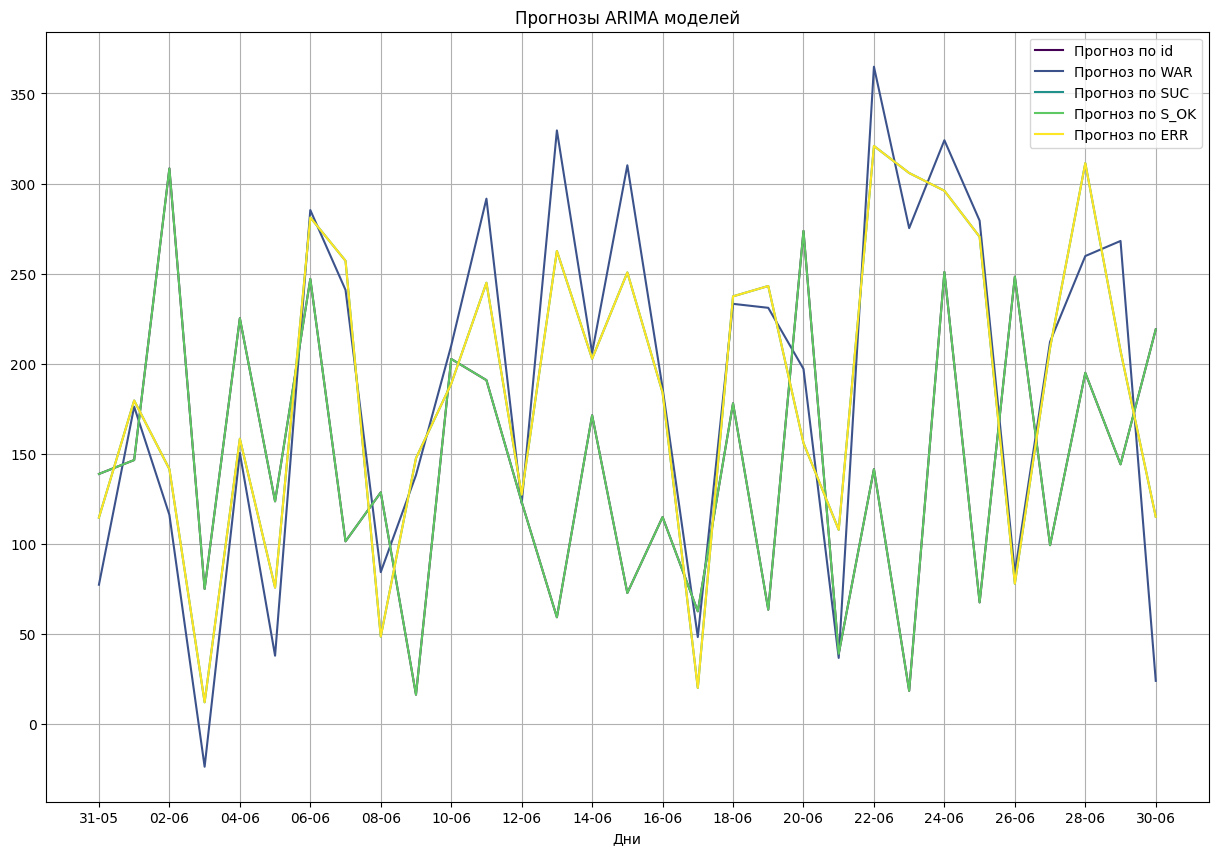

In [25]:

#Выбор лучших парамтером для каждого файла
orders = [(19, 1, 19),(20, 0, 1),(20, 0, 2),(19, 1, 19),(20, 0, 2)]
#Масств имен
names = ['id','WAR','SUC','S_OK','ERR']

warnings.simplefilter(action='ignore', category=Warning) # Игнорируем все предупреждения
date_form = mdates.DateFormatter("%d-%m") # Формат даты для оси X
plt.figure(figsize=(15, 10))# Создаем новый график с указанным размером

# Цвета для каждого прогноза
colors = plt.cm.viridis(np.linspace(0, 1, len(allGr)))

# Итерируемся по каждому графику и строим прогнозы
for graf, order, name, color in zip(allGr, orders, names, colors):
    
    num_points = graf.shape[0]#Кол-во точек на графике
    
    # Обучаем модель ARIMA
    model = ARIMA(graf, order=order)
    model.initialize_approximate_diffuse()# Инициализация диффузных значений
    result = model.fit()# Обучение модели и получение результатов
    
   
    forecast_periods = num_points  # количество точек во временном ряду вперед
    predictions = result.predict(start=len(graf), end=len(graf) + forecast_periods - 1)# Прогнозируем результаты

    # Генерация диапазона дат для прогнозов
    date_range = pd.date_range(start=graf.index[-1], periods=forecast_periods + 1, freq='D')[1:]# Генерируем диапазон дат для прогнозов
    predictions.index = date_range # Индексируем прогнозы по дате

    
    plt.plot(predictions, label=f'Прогноз по {name}', linestyle='-', color=color)# Строим график только для прогнозов с разными цветами

plt.xlabel('Дни')  # Устанавливаем подпись оси X

plt.gca().xaxis.set_major_formatter(date_form)# Устанавливаем формат даты на оси X
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))# Устанавливаем интервал между днями на оси X
plt.title('Прогнозы ARIMA моделей')# Устанавливаем заголовок графика
plt.legend()# Добавляем легенду
plt.grid() # Включаем сетку на графике

plt.show()  # Показываем график
